# ScentSales: Forecasting Perfume Sales using Statistical & Machine Learning Techniques

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy import stats
from scipy.stats import f
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [21]:
df = pd.read_excel(r"C:\Users\NadaF\Downloads\rere.xlsx")
print(df.head())

             Perfume_Name  Price_USD  Size_ml  Sales_Volume
0               Miss Dior      97.51       90          5791
1                   YSL Y      32.34       75          8558
2                  My Way     123.57      150          3347
3  Versace Bright Crystal      47.94      150          5693
4       Mont Blanc Legend     100.04       50          7411


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Perfume_Name  70 non-null     object 
 1   Price_USD     70 non-null     float64
 2   Size_ml       70 non-null     int64  
 3   Sales_Volume  70 non-null     int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 2.3+ KB


In [3]:
df.describe()

,Price_USD,Size_ml,Sales_Volume
count,70.000000,70.000000,70.000000
mean,76.891571,87.071429,5004.914286
std,26.048862,40.167158,2355.012230
min,32.340000,30.000000,1232.000000
25%,52.095000,50.000000,3263.500000
50%,76.735000,75.000000,5088.500000
75%,96.412500,100.000000,6325.250000
max,125.060000,150.000000,9596.000000


In [4]:
X = df[['Price_USD', 'Size_ml']].values
Y=df['Sales_Volume'].values

In [5]:
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y.reshape(-1, 1)).flatten()

In [6]:
class MultipleLinearRegression:
    def __init__(self):
        self.weights = None  
        self.SSE = None      
        self.SSR = None    
        self.SSE = float('inf')
        self.MSE = None    
        self.r_squared = None 
        self.F_stat = None   
        self.n = None        
        self.p = None
        self.coefficients = None

    def sum_of_squared_errors(self, Y, pred):
        return np.sum((Y - pred) ** 2)
    

    def fit(self, X, Y, learning_rate=0.01, epochs=500, tolerance=1e-6):
        X = np.array(X)
        Y = np.array(Y)

        num_samples, num_features = X.shape
        X = np.c_[np.ones((num_samples, 1)), X]
        self.weights = np.zeros(num_features + 1)

        for _ in range(epochs):
            pred = self.predict(X[:, 1:])
            dw = np.dot(X.T, (pred - Y)) / num_samples
            self.weights -= learning_rate * dw

            new_loss = self.sum_of_squared_errors(Y, pred)

            if abs(new_loss - self.SSE) < tolerance:
                break

            self.SSE = new_loss

        self.MSE = self.SSE / num_samples
        self.coefficients = self.weights
        return self
    



    def predict(self, X):
        if self.weights is None:
            raise ValueError("Model is not trained yet.")

        if X.shape[1] == len(self.weights) - 1:
            X = np.c_[np.ones((X.shape[0], 1)), X]

        return np.dot(X, self.weights)
    



    def anova(self, X_col, Y):
        X_col = np.array(X_col)
        Y = np.array(Y)
        self.n = len(X_col)

        x_mean = np.mean(X_col)
        y_mean = np.mean(Y)
        self.x_bar = x_mean

        self.SXX = np.sum((X_col - x_mean)**2)
        SXY = np.sum((X_col - x_mean) * (Y - y_mean))
        self.B_1 = SXY / self.SXX
        self.B_0 = y_mean - self.B_1 * x_mean

        y_pred = self.B_0 + self.B_1 * X_col

        SSR = np.sum((y_pred - y_mean)**2)
        SSE = np.sum((Y - y_pred)**2)
        SST = np.sum((Y - y_mean)**2)

        self.df_regression = 1
        self.df_error = self.n - 2
        df_total = self.n - 1

        MSR = SSR / self.df_regression
        self.MSE = SSE / self.df_error

        self.F_stat = MSR / self.MSE

        anova_table = pd.DataFrame({
            'Source': ['Regression', 'Error', 'Total'],
            'SS': [SSR, SSE, SST],
            'df': [self.df_regression, self.df_error, df_total],
            'MS': [MSR, self.MSE, np.nan],
            'F': [self.F_stat, np.nan, np.nan]
        })

        return anova_table
    


    
    def hypothesis_test(self, X_col, Y, alpha=0.05):
     
        anova_table = self.anova(X_col, Y)
    
        F_stat = anova_table.loc[0, 'F']
        F_critical = f.ppf(1 - alpha, anova_table.loc[0, 'df'], anova_table.loc[1, 'df'])
    
        decision = "Reject H₀ (Significant)" if F_stat > F_critical else "Fail to Reject H₀ (Not Significant)"
    
        result = pd.DataFrame({
        'Feature': [X_col.name],
        'F-statistic': [round(F_stat, 4)],
        'F-critical': [round(F_critical, 4)],
        'Alpha': [alpha],
        'Decision': [decision]
    })

        return result
    

    def interval_estimation(self,X_col, Y, alpha=0.05, sigma=None):
        self.anova(X_col, Y)
        if sigma is None:
            t = scipy.stats.t.ppf(1 - alpha / 2, self.df_error)  #Computes the t-distribution's critical value at a specified confidence leve
            B_0_margin = t * np.sqrt(self.MSE * ((1 / self.n) + (self.x_bar ** 2 / self.SXX)))
            B_1_margin = t * np.sqrt(self.MSE / self.SXX)
        else:
            z = scipy.stats.norm.ppf(1 - alpha / 2)
            B_0_margin = z * sigma * np.sqrt((1 / self.n) + (self.x_bar ** 2 / self.SXX))
            B_1_margin = z * sigma * np.sqrt(1 / self.SXX)

        B_0_interval = [self.B_0 - B_0_margin, self.B_0 + B_0_margin]
        B_1_interval = [self.B_1 - B_1_margin, self.B_1 + B_1_margin]

        print(f"Confidence Interval for B_0: {B_0_interval}")
        print(f"Confidence Interval for B_1: {B_1_interval}")
        return B_0_interval, B_1_interval
    



    def plot_3d(self, X_raw, Y_raw):
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X_raw[:, 0], X_raw[:, 1], Y_raw, c='purple', marker='o')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.set_zlabel('Target')
        ax.set_title('3D Scatter Plot')
        plt.show()
    
    

In [7]:
model = MultipleLinearRegression()

In [8]:
model.fit(X_scaled, Y_scaled, learning_rate=0.001)
print(f'Line of best fit is: y = {model.weights[0]} + {model.weights[1]}x1 + {model.weights[2]}x2')

Line of best fit is: y = -6.006663420622869e-17 + 0.054470056202383745x1 + 0.04869192933778012x2


In [9]:
print("Evaluation of the model")
print(" ---------------------------------------- ")
print("Weights (coefficients):", model.weights)
print("Mean Squared Error (MSE):", model.MSE)

Evaluation of the model
 ---------------------------------------- 
Weights (coefficients): [-6.00666342e-17  5.44700562e-02  4.86919293e-02]
Mean Squared Error (MSE): 0.9782401937749164


In [10]:
predictions = model.predict(np.array([6, 7]).reshape(1, -1))  # Convert [6, 7] to a NumPy array with shape (1, 2) 
print(predictions)

predicted = scaler_Y.inverse_transform(predictions.reshape(-1, 1)).flatten()
df.head()

[0.66766384]


,Perfume_Name,Price_USD,Size_ml,Sales_Volume
0,Miss Dior,97.51,90,5791
1,YSL Y,32.34,75,8558
2,My Way,123.57,150,3347
3,Versace Bright Crystal,47.94,150,5693
4,Mont Blanc Legend,100.04,50,7411


In [11]:
print("ANOVA for Price_USD:")
print(model.anova(df['Price_USD'], df['Sales_Volume']))

print("\nANOVA for Size_ml:")
print(model.anova(df['Size_ml'], df['Sales_Volume']))

ANOVA for Price_USD:
       Source            SS  df            MS        F
0  Regression  7.331870e+06   1  7.331870e+06  1.32828
1       Error  3.753478e+08  68  5.519821e+06      NaN
2       Total  3.826797e+08  69           NaN      NaN

ANOVA for Size_ml:
       Source            SS  df            MS        F
0  Regression  5.859606e+06   1  5.859606e+06  1.05741
1       Error  3.768201e+08  68  5.541472e+06      NaN
2       Total  3.826797e+08  69           NaN      NaN


No significant between features and target

In [12]:
print(model.hypothesis_test(df['Price_USD'], df['Sales_Volume']))
print(model.hypothesis_test(df['Size_ml'], df['Sales_Volume']))

     Feature  F-statistic  F-critical  Alpha  \
0  Price_USD       1.3283      3.9819   0.05   

                              Decision  
0  Fail to Reject H₀ (Not Significant)  
   Feature  F-statistic  F-critical  Alpha  \
0  Size_ml       1.0574      3.9819   0.05   

                              Decision  
0  Fail to Reject H₀ (Not Significant)  


In [13]:
print("Interval estimation for Price_USD: \n==================================" )
print(model.interval_estimation(df['Price_USD'],df['Sales_Volume']))

print("\n\n")
print("Interval estimation for Price_USD: \n====================================")
print(model.interval_estimation(df['Size_ml'],df['Sales_Volume']))

Interval estimation for Price_USD: 
Confidence Interval for B_0: [2284.994725752739, 5800.400808981194]
Confidence Interval for B_1: [-9.15282944291744, 34.18070962458786]
([2284.994725752739, 5800.400808981194], [-9.15282944291744, 34.18070962458786])



Interval estimation for Price_USD: 
Confidence Interval for B_0: [3024.90225278396, 5721.516535252318]
Confidence Interval for B_1: [-6.823659023640948, 21.333697553166886]
([3024.90225278396, 5721.516535252318], [-6.823659023640948, 21.333697553166886])


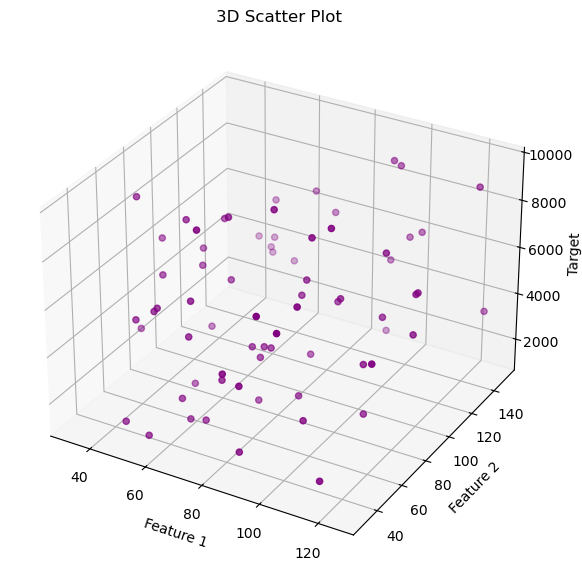

In [14]:
model.plot_3d(X, Y)

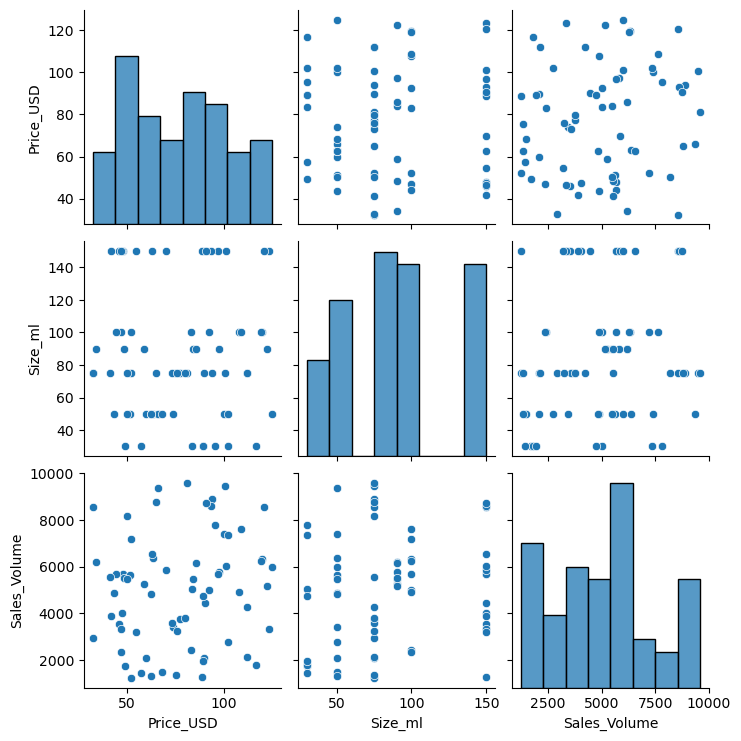

In [15]:
sns.pairplot(df)
plt.show()

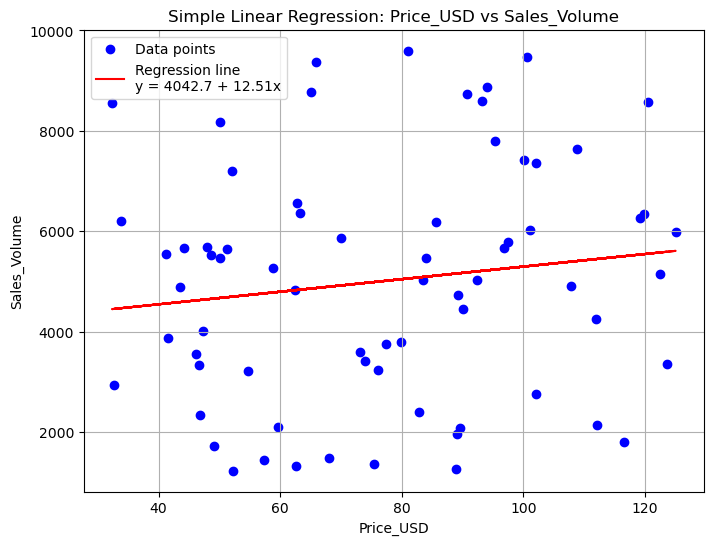

In [16]:
X_col = df['Price_USD'].values
Y = df['Sales_Volume'].values
x_mean = np.mean(X_col)
y_mean = np.mean(Y)

SXX = np.sum((X_col - x_mean)**2)
SXY = np.sum((X_col - x_mean) * (Y - y_mean))
B1 = SXY / SXX
B0 = y_mean - B1 * x_mean

Y_pred = B0 + B1 * X_col

plt.figure(figsize=(8,6))
plt.scatter(X_col, Y, color='blue', label='Data points')
plt.plot(X_col, Y_pred, color='red', label=f'Regression line\ny = {round(B0, 2)} + {round(B1, 2)}x')
plt.title('Simple Linear Regression: Price_USD vs Sales_Volume')
plt.xlabel('Price_USD')
plt.ylabel('Sales_Volume')
plt.legend()
plt.grid(True)
plt.show()


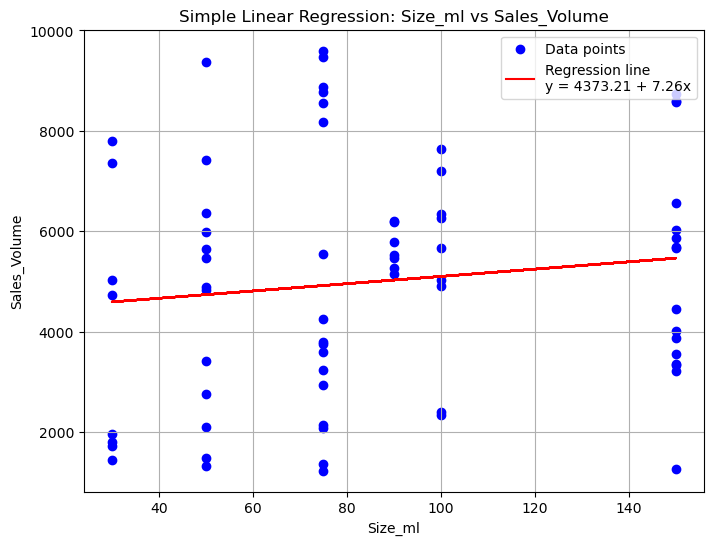

In [17]:
X_col = df['Size_ml'].values
Y = df['Sales_Volume'].values
x_mean = np.mean(X_col)
y_mean = np.mean(Y)

SXX = np.sum((X_col - x_mean)**2)
SXY = np.sum((X_col - x_mean) * (Y - y_mean))
B1 = SXY / SXX
B0 = y_mean - B1 * x_mean

Y_pred = B0 + B1 * X_col

plt.figure(figsize=(8,6))
plt.scatter(X_col, Y, color='blue', label='Data points')
plt.plot(X_col, Y_pred, color='red', label=f'Regression line\ny = {round(B0, 2)} + {round(B1, 2)}x')
plt.title('Simple Linear Regression: Size_ml vs Sales_Volume')
plt.xlabel('Size_ml')
plt.ylabel('Sales_Volume')
plt.legend()
plt.grid(True)
plt.show()


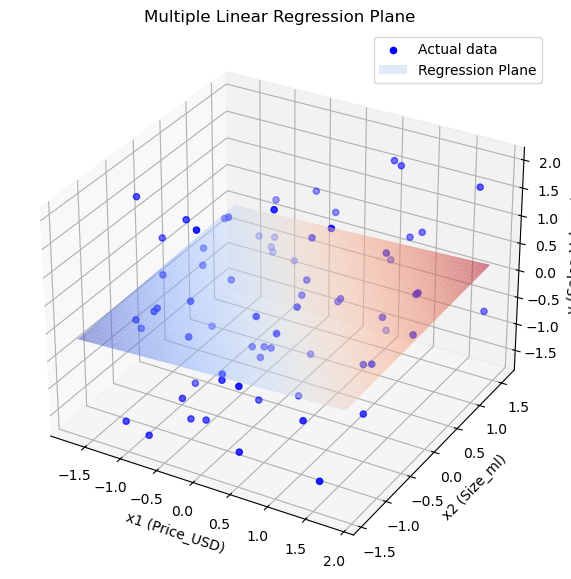

In [18]:
x1 = X_scaled[:, 0]
x2 = X_scaled[:, 1]
y = Y_scaled

x1_range = np.linspace(min(x1), max(x1), 50)
x2_range = np.linspace(min(x2), max(x2), 50)
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)

y_pred_grid = (
    model.weights[0] + 
    model.weights[1] * x1_grid + 
    model.weights[2] * x2_grid
)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x1, x2, y, color='blue', label='Actual data')

ax.plot_surface(x1_grid, x2_grid, y_pred_grid, alpha=0.5, cmap=cm.coolwarm, label='Regression Plane')

ax.set_xlabel('x1 (Price_USD)')
ax.set_ylabel('x2 (Size_ml)')
ax.set_zlabel('y (Sales_Volume)')
ax.set_title('Multiple Linear Regression Plane')
plt.legend()
plt.show()
